# Lecture 7: Feature Engineering Solutions
***

<img src="figs/logregwordcloud.png" width=1100 height=50>

**Reminder**:  Go to the botttom of the notebook and shift-enter the [helper functions](#helpers)
***



The success of a machine learning algorithm on a predictive problem is highly dependent on the way you as the practitioner present the data. Consider the following example. 

### Problem 1: Intuition
***
Suppose that you want to train a model to predict whether it is possible to drive between two cities in a single day.  The raw data includes the latitude and longitude of the two cities and the training data is labeled with $\texttt{Yes}$ for is drivable and $\texttt{No}$ for is not drivable.  One particular training set my look like 

|$\texttt{CITY 1 LAT.}$ | $\texttt{CITY 1 LNG.}$ |$\texttt{CITY 2 LAT.}$ | $\texttt{CITY 2 LNG.}$ | $\texttt{DRIVABLE}$? | 
|:----:|:----:|:----:|:----:|:----:|
| 123.24 |46.71	| 121.33| 47.34	| Yes |
|123.24	|56.91	|121.33	|55.23	|Yes |
|123.24	|46.71	|121.33	|55.34	|No |
|123.24	|46.71	|130.99	|47.34	|No |

**Q**: Given the following features, do you expect a linear classifier like Logistic Regression to be successful? 

**A**: Probably not.  The issue here is that Logistic Regression will look at each of the features linearly and try to use a combination of each to make a prediction.  But notice that not a single one of the features is strongly correlated with the label.  It's clear that in order to make an accurate prediction the features have to interact, and they have to interact in a potentially complicated way.  

**Q**: What features could you create that *would* be correlated with the correct classification? 

**A**: Somehow we have to encode an idea of distance between the two cities in order to make a prediction.  The most obvious answer is to use the given features to create a derived feature that encodes distance, i.e. 

$$
\texttt{Distance} = \sqrt{(\texttt{CITY 1 LAT.} -\texttt{CITY 2 LAT.})^2 + (\texttt{CITY 2 LNG.} -\texttt{CITY 1 LNG.})^2 }
$$

If we convert the following measurements to miles then we have the following table 

|$\texttt{DISTANCE}$ | $\texttt{DRIVABLE}$? | 
|:----:|:----:|:----:|:----:|:----:|
| 14	| Yes |
| 28	|Yes |
| 705   |No |
| 2432  |No |

Clearly, the derived feature of distance is strongly correlated with drivablility and will thus be a good feature to include in the model (in fact, you probably want to use this feature and dump the lat-long features entirely). 

**Q**: Could we come up with a process to do this automatically?  Next question:  should we come up with a process to do this automatically? 

**A**:  Meh... We could throw a bunch of derived polynomials terms into the mix and then do some feature selection method (we'll learn about Lasso next week) and see if it throws out the useless features.  But in this case we saved a lot of time by using common sense (i.e. domain knowledge). 



<br>

### Problem 2: Transformations on Continuous Data 
***

Consider the case when you're trying to model quality of life of a person from survey data which asks a multitude of things like $\texttt{income}$, $\texttt{education level}$, $\texttt{num children}$, etc.  As part of data exploration, you might try plotting the distributions of the raw data by feature individually.  A histogram of a potential data set for income might look as follows:  


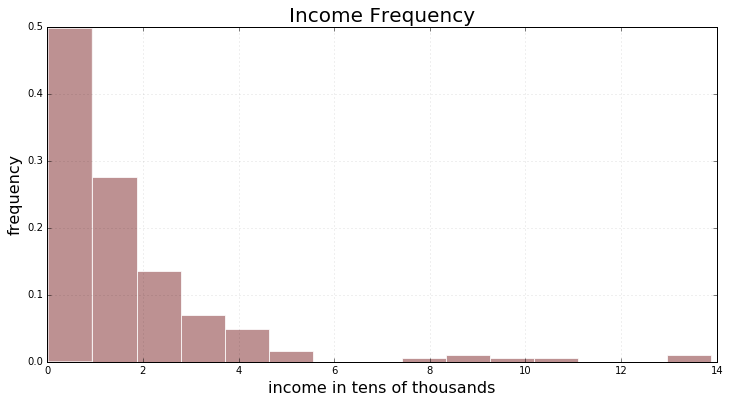

In [4]:
x_inc = income_data()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
n, bins, patches = ax.hist(x_inc, 15, normed=1, facecolor=mycolors["red"], alpha=0.75, edgecolor="white")
ax.set_xlabel("income in tens of thousands", fontsize=16)
ax.set_ylabel("frequency", fontsize=16);
ax.set_title("Income Frequency", fontsize=20);
ax.grid(alpha=0.25)

This looks like we would expect for income.  There are lots of people at the low end of the spectrum, a few more in the middle, and very few in the high income categories.  

There are two things to consider here.  First, lots of ML models assume that your input features are generally normally distributed.  Second, from a feature engineering perspective, we can think about how much income actually affects happiness.  It seems reasonable to believe that once you get to a certain level, increasing income has a diminishing effect on happiness.  

Both of these viewpoints motivate us to try a log transformation on the data. 

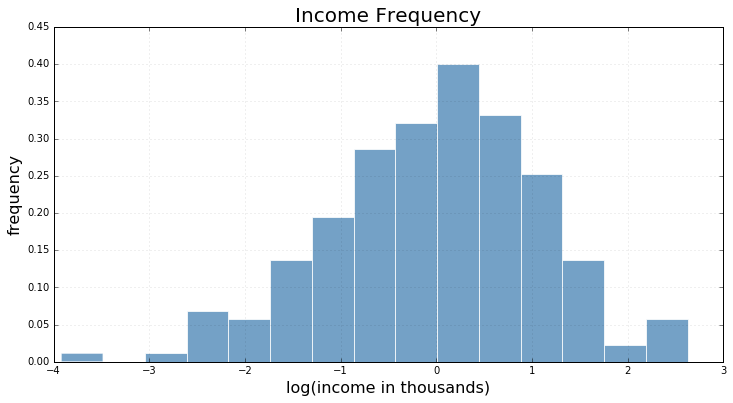

In [5]:
x_inc_log = np.log(x_inc)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
n, bins, patches = ax.hist(x_inc_log, 15, normed=1, facecolor=mycolors["blue"], alpha=0.75, edgecolor="white")
ax.set_xlabel("log(income in thousands)", fontsize=16)
ax.set_ylabel("frequency", fontsize=16);
ax.set_title("Income Frequency", fontsize=20);
ax.grid(alpha=0.25)

This results in a distribution that looks fairly Gaussian, which might perform better in an machine learning model. 

<br>

### Problem 3: Categorical Data 
*** 

Encoding categorical data can be tricky.  Consider the case when you have a raw feature in your model that corresponds to a person's hair color.  Possible values might be $\texttt{blonde}$, $\texttt{brunette}$, $\texttt{redhead}$.  How should we encode these as numerical models in a ML algorithm? 

A natural (but misleading) thing to do would be to assign an integer to each possible value of the feature.  For instance, we could do 

|Religion| Feature|
|:-------:|:------:|
|blonde| 0 |
|brunette | 1 | 
|redhead | 2|

**Q**:  What is potentially wrong with this encoding, particularly in a regression context? 

**A**: The problem is that we imposed on the possible values an ordinal ordering which does not exist, i.e. blonde > brunette > redhead.   

One way to fix this is create binary features corresponding to each religion.  That is, we create a binary $\texttt{IsBlonde}$ variable, a binary $\texttt{IsBrunette}$ variable, etc.  We then have 

|Religion| $\texttt{IsBlonde}$ | $\texttt{IsBrunette}$ | $\texttt{IsRedhead}$| 
|:-------:|:------:|:------:|:------:|
|Blonde| 1 | 0 | 0 | 
|Brunette | 0 | 1 | 0 | 
| Redhead | 0| 0 | 1 

This process is called *one-hot-encoding* and is very frequently used to encode categorical data. 


<br><br>


### Problem 4: Temporal Data 
*** 

Suppose that you're trying to train a model to predict that amount of foot-traffic at the 29th Street Mall.  Mall managers might be interested in such a model to predict the amount of janitorial and security services they need to employ at different times.  

Suppose your training data consists of measurements of the amount of foot traffic at the mall and the date/time stamps that they were measured.  For instance, a training set might look like 

|$\texttt{date_time_stamp}$| $\texttt{FootTraffic}$|
|:-------:|:------:|
|$\texttt{2015-11-12-20:00}$| 70|
|$\texttt{2015-06-10-21:00}$| 100|
|$\texttt{2015-08-02-12:00}$| 120|
|$\texttt{2015-12-22-12:00}$| 20|


**Q**: How might you create meaningful features on the $\texttt{date_time_stamp}$ data that would be useful for prediction? 


**A**: You could do loads of things.  For starters you probably want to separate the dates and times.  Then you might create a feature like $\texttt{isCloseToHoliday}$ or features that indicate which season it is (since foot traffic might go up during summer when all of the mall rats are out of school). 



<br>
<br>

### Problem 5: Part-of-Speech-Tagging
*This problem and associated code was adapted from Jordan Boyd-Graber*
***

In computational linguistics, part-of-speech tagging (POST) is the process of marking a word in a text as a particular part of speech (e.g. noun, verb, adjective, etc), based on both its definition and its context. 

In this problem we will work with the <a href="https://en.wikipedia.org/wiki/Brown_Corpus">Brown Corpus</a>, a compilation of 500 samples of English-language text totaling over a million words. The Brown Corpus is available through python's <a href="http://www.nltk.org/">Natural Language Toolkit</a>.  Each word in the corpus has been tagged as: 

|type|symbol|
|:--:|:----:|
|adjective| JJ|
|noun|NN|
|pronoun|PP|
|adverb|RB|
|verb|VB|

For the classification we will use simple Logistic Regression and focus on making iterative improvements by adding good features to our model.  The code for this problem is located in the helper functions section below.  Scroll down now and take a look at the code. 

**Creating a Baseline**: When starting to evaluate the usefulness of features, it is usually a good idea to create a baseline.  That is, run your model with little to no features and see how the model performs.  The following code will run logistic regression with only a bias feature. 

In [6]:
part_of_speech(limit=500)

Example Features:



Training Set
-------------------------
Accuracy: 0.526002

Confusion Matrix:

JJ	NN	PP	RB	VB
0	522	0	0	0
0	2205	0	0	0
0	278	0	0	0
0	179	0	0	0
0	1008	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos: NN      true pos: PP
word: it          prediced pos: NN      true pos: PP
word: his         prediced pos: NN      true pos: PP
word: He          prediced pos: NN      true pos: PP
word: its         prediced pos: NN      true pos: PP
word: It          prediced pos: NN      true pos: PP
word: federal     prediced pos: NN      true pos: JJ
word: medical     prediced pos: NN      true pos: JJ
word: new         prediced pos: NN      true pos: JJ

Validation Set
--------------------
Accuracy: 0.560999

Confusion Matrix:

JJ	NN	PP	RB	VB
0	129	0	0	0
0	584	0	0	0
0	59	0	0	0
0	35	0	0	0
0	234	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos

OK, so now we know that simply making predictions based on the number of occurrences of each type of speech leads to a *training accuracy* of around 52% and a *validation accuracy* of around 56%.  Hopefully we can improve on this by actually giving the model some useful features.  

The obvious choice is to actually tell the model what the words is. 

In [7]:
part_of_speech(limit=500, word=True)

Example Features:

County
Grand
Jury
said
investigation
recent
primary
election
produced
evidence
irregularities
took
place


Training Set
-------------------------
Accuracy: 0.962309

Confusion Matrix:

JJ	NN	PP	RB	VB
515	6	0	0	1
12	2186	1	1	5
0	9	269	0	0
6	75	0	98	0
2	38	0	2	966

Some misclassified examples:

word: increase    prediced pos: NN      true pos: VB
word: public      prediced pos: JJ      true pos: NN
word: back        prediced pos: RB      true pos: VB
word: Executive   prediced pos: NN      true pos: JJ
word: issue       prediced pos: NN      true pos: VB
word: report      prediced pos: NN      true pos: VB
word: further     prediced pos: JJ      true pos: RB
word: place       prediced pos: NN      true pos: VB
word: pay         prediced pos: VB      true pos: NN
word: plans       prediced pos: NN      true pos: VB

Validation Set
--------------------
Accuracy: 0.792507

Confusion Matrix:

JJ	NN	PP	RB	VB
63	65	0	1	0
4	574	0	0	6
0	6	53	0	0
2	19	0	14	0
0	113	0	0	121

Some

OK, that seems more reasonable.  Now you should have a training accuracy of around 96% and a validation accuracy of around 79%.  It looks like using the words alone as features induces some overfitting on the training set. Let's see if we can think of new features that we could include that might help.  

Here is where you have to use your brain to do feature engineering!  

The code has output some useful information that you can use to do error analysis and hopefully come up with some useful features.  

The top of the output gives you examples of the features that were used for several examples.  Since we only used the words as features, each example only includes the word itself. 

The next useful piece of information is shown in the *confusion matrix*. Sci-Kit Learn's confusion matrix function returns a matric $C$ such that $C_{ij}$ gives the number of examples known to be in group $i$ that were labeled as group $j$.  From the confusion matrix in the output we see that, in particular, the model is classifying a lot of words that should be verbs as nouns.   

Now, based on this knowledge you might have some ideas about new features you can include to combat this error, but maybe you don't?  It's almost always a good idea to dig into the actual data and look at *specific* examples that your model has misclassified.  To help you with this, the code has printed some of the most common misclassifications.  

**Q**: Looking at the common misclassifications, can you think of a good new feature to add? 

Add your new feature to the model and see how it does! 

In [8]:
part_of_speech(limit=500, )

Example Features:



Training Set
-------------------------
Accuracy: 0.526002

Confusion Matrix:

JJ	NN	PP	RB	VB
0	522	0	0	0
0	2205	0	0	0
0	278	0	0	0
0	179	0	0	0
0	1008	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos: NN      true pos: PP
word: it          prediced pos: NN      true pos: PP
word: his         prediced pos: NN      true pos: PP
word: He          prediced pos: NN      true pos: PP
word: its         prediced pos: NN      true pos: PP
word: It          prediced pos: NN      true pos: PP
word: federal     prediced pos: NN      true pos: JJ
word: medical     prediced pos: NN      true pos: JJ
word: new         prediced pos: NN      true pos: JJ

Validation Set
--------------------
Accuracy: 0.560999

Confusion Matrix:

JJ	NN	PP	RB	VB
0	129	0	0	0
0	584	0	0	0
0	59	0	0	0
0	35	0	0	0
0	234	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos

**Q**:  Did your model do better on the test data?  Take a look at the confusion matrix and the examples of misclassifications and see if you can think of another new feature to add! 

In [9]:
part_of_speech(limit=500, )

Example Features:



Training Set
-------------------------
Accuracy: 0.526002

Confusion Matrix:

JJ	NN	PP	RB	VB
0	522	0	0	0
0	2205	0	0	0
0	278	0	0	0
0	179	0	0	0
0	1008	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos: NN      true pos: PP
word: it          prediced pos: NN      true pos: PP
word: his         prediced pos: NN      true pos: PP
word: He          prediced pos: NN      true pos: PP
word: its         prediced pos: NN      true pos: PP
word: It          prediced pos: NN      true pos: PP
word: federal     prediced pos: NN      true pos: JJ
word: medical     prediced pos: NN      true pos: JJ
word: new         prediced pos: NN      true pos: JJ

Validation Set
--------------------
Accuracy: 0.560999

Confusion Matrix:

JJ	NN	PP	RB	VB
0	129	0	0	0
0	584	0	0	0
0	59	0	0	0
0	35	0	0	0
0	234	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos

**Q**:  What's your performance like now?  Repeat this iterative process of adding new features until you're happy with your model (or you've exhausted the number of features available in the code) 

In [10]:
part_of_speech(limit=500, )

Example Features:



Training Set
-------------------------
Accuracy: 0.526002

Confusion Matrix:

JJ	NN	PP	RB	VB
0	522	0	0	0
0	2205	0	0	0
0	278	0	0	0
0	179	0	0	0
0	1008	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos: NN      true pos: PP
word: it          prediced pos: NN      true pos: PP
word: his         prediced pos: NN      true pos: PP
word: He          prediced pos: NN      true pos: PP
word: its         prediced pos: NN      true pos: PP
word: It          prediced pos: NN      true pos: PP
word: federal     prediced pos: NN      true pos: JJ
word: medical     prediced pos: NN      true pos: JJ
word: new         prediced pos: NN      true pos: JJ

Validation Set
--------------------
Accuracy: 0.560999

Confusion Matrix:

JJ	NN	PP	RB	VB
0	129	0	0	0
0	584	0	0	0
0	59	0	0	0
0	35	0	0	0
0	234	0	0	0

Some misclassified examples:

word: said        prediced pos: NN      true pos: VB
word: he          prediced pos



<br>
<br>

### Problem 6: Building Multiple Features in SKLearn with Custom Transformers and FeatureUnion
***

In the Feature Engineering assignment your goal is to hand-craft features to predict whether statements about TV shows contain spoilers or not.  There are endless possibilities for useful features that you might want to try out, but for those of you not familiar with text-learning in sklearn just the process of getting up and running might seem daunting.  In this problem I will demonstrate the use of two particular objects that may make your life significantly easier: the generic Transformer and the FeatureUnion pipeline.  We will also make use of the CountVectorizer which is similar to the HashVectorizer seen in Problem 5.  If you have significant experience in text-learning then you have likely seen these things before (and/or know better things) and can safely skip this exercise. 

For the purpose of this discussion we will assume, like in the homework, that our data is a list of sentence strings.  For instance, we might have: 

In [11]:
train = [
    "The quick brown fox jumped over the lazy lazy dog",
    "There is that dog and fox again"
]

If we want to turn these data into a vectorized bag-of-word representation we can use an instance of **CountVectorizer, which is a simple transformer that turns raw text into bag-or-words vectors.**  To make the number of word-features more manageable I will call CountVectorizer with a list of stop words to be removed.  

To transform the data into a matrix I simply call the $\texttt{fit_transform}$ method on the data. 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

bag_of_words = CountVectorizer(stop_words='english')
X = bag_of_words.fit_transform(train)

If I want to see the names of the specific features created (and important for our purpose, the order in which they're encoded) I can call the $\texttt{get_feature_names}$ method. 

In [13]:
print("The named features are ", bag_of_words.get_feature_names())

The named features are  ['brown', 'dog', 'fox', 'jumped', 'lazy', 'quick']


Notice that CountVectorizer removed most of the common words like "the", "there", "is" and "and" and stores the important words in alphabetical order. 

Let's check the type and shape of the matrix produced by the transformer. 

In [14]:
print("X has type ", type(X))
print("X has shape ", X.shape)

X has type  <class 'scipy.sparse.csr.csr_matrix'>
X has shape  (2, 6)


So CountVectorizer returns our vectorized features as a sparse matrix.  This makes sense since most feature vectors in text applications only contain a handful of vocabulary words and are therefore very sparse. 

Finally, the matrix X has two rows and six columns.  Each row corresponds to a training example (a sentence) and each column to a word-feature with the order corresponding to the list returned by $\texttt{get_feature_names}$. 

Let's look at the matrix and see if it does what we think it's doing. 

In [15]:
print(X.todense())

[[1 1 1 1 2 1]
 [0 1 1 0 0 0]]


The first row of X should refer to the first sentence in $\texttt{train}$

In [16]:
print(train[0])

The quick brown fox jumped over the lazy lazy dog


Notice that the first column refers to instances of "brown", and the fifth column refers to instances of "lazy".  OK, so there's an example of a simple canned transformer that we can apply to raw text-data.  But what if we want to craft something a little less standard?  What if, for instance, we're convinced that the number of times the characters "x", "y", and "z" appear in a sentence is somehow an important feature (probably not, but just go with it).  How could add these features to our data matrix?   

There are definitely simple hacky ways to do this, but one slick way is to write your own custom transformer.  This transformer will take in raw text-data, turn them into numeric feature vectors (counts of the number of "x", "y", and "z"s) and return the matrix of transformed data.  One such transformer might look as follows  


In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

class XYZTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, examples):
        # return self and nothing else 
        return self
    
    def transform(self, examples):
        
        import numpy as np 
        from scipy.sparse import csr_matrix
        
        letters = ['x', 'y', 'z']
         
        # Initiaize matrix 
        X = np.zeros((len(examples), len(letters)))
        
        # Loop over examples and count letters 
        for ii, x in enumerate(examples):
            X[ii,:] = np.array([x.count(letter) for letter in letters])
            
        return csr_matrix(X) 

Essentially we're writing a class that takes in the type of data we expect, transforms it the way we expect, and returns it the way we expect.  One thing to note is that by convention the transformer contains a $\texttt{fit}$ method that only results $\texttt{self}$.  All of the magic actually happens in the $\texttt{transform}$ method. 

Let's test it out on our simple training data and see if it does what we expect.  Remember that the sentences in the training data are 

In [18]:
print(train[0])
print(train[1])

The quick brown fox jumped over the lazy lazy dog
There is that dog and fox again


In [19]:
# Create an instance of the XYZTransformer 
xyz = XYZTransformer()

# Fit it to our data 
Y = xyz.fit_transform(train)

# Print a dense version of the matrix 
print(Y.todense())

[[ 1.  2.  2.]
 [ 1.  0.  0.]]


Note that the first row (corresponding to the first sentence in the data) indicates that there is 1 x, 2 y's, and 2 z's in the first sentence, which you can verify is correct.  Similarly, the second row indicates that there is a single x (from "fox") in the sentence and no y's or z's. 

OK, so you've built your first transformer.  Now, let's say we want to combine the bag-of-words vectors and the letter features into a single data matrix.  We can do this with a particular class called a $\texttt{FeatureUnion}$.  If you're familiar with sklearn's pipelines, know that a $\texttt{FeatureUnion}$ is a pipeline specifically designed for transformer objects. 

Now we'll combine our two transformers into a mega-transformer that will zip all of our features into a nice package.  It might look as follows: 

In [20]:
from sklearn.pipeline import FeatureUnion

allmyfeatures = FeatureUnion([
        ("bag-of-words", CountVectorizer(stop_words='english')),
        ("letter-counts", XYZTransformer())
    ])

Now we'll call our mega-transformer on the original data, and hopefully get a sparse matrix out that encapsulates all of the features. 

In [21]:
Z = allmyfeatures.fit_transform(train)
print("Z has type ", type(Z))
print("Z has shape ", Z.shape)

Z has type  <class 'scipy.sparse.csr.csr_matrix'>
Z has shape  (2, 9)


Note that the combined data matrix Z is again a csr matrix (by design) and has two rows and nine columns.  The two rows again correspond to the two pieces of data in the train set, and the nine columns correspond to the six bag-of-word features from CountVectorizer and the three letter count features from XYZTransformer.  If we print a dense version of Z ... 

In [22]:
print(Z.todense())

[[ 1.  1.  1.  1.  2.  1.  1.  2.  2.]
 [ 0.  1.  1.  0.  0.  0.  1.  0.  0.]]


you will see that it looks exactly like the data matrices X and Y concatenated side-by-side. 

This is certainly not the only way to combine features from different transformers, but in my experience it is definitely one of the cleanest, especially when working with many types of hand-crafted features. 

<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
<br><br><br><br>

<a id='helpers'></a>

<br> 

### Helper Functions
***

In [3]:
from collections import defaultdict
import string
import operator

import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score

import nltk
nltk.download('wordnet')
nltk.download('brown')

from nltk.corpus import wordnet as wn
from nltk.corpus import brown
from nltk.util import ngrams

import seaborn as sn 
import matplotlib.pyplot as plt
%matplotlib inline

mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}


def normalize_tags(tag):
    if not tag or not tag[0] in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
        return "PUNC"
    else:
        return tag[:2]


kTAGSET = ["", "JJ", "NN", "PP", "RB", "VB"]

class Analyzer:
    def __init__(self, word, before, after, prev, next, char, dict):
        self.word = word
        self.after = after
        self.before = before
        self.prev = prev
        self.next = next
        self.dict = dict
        self.char = char

    def __call__(self, feature_string):
        feats = feature_string.split()

        if self.word:
            yield feats[0]

        if self.after:
            for ii in [x for x in feats if x.startswith("A:")]:
                yield ii
        if self.before:
            for ii in [x for x in feats if x.startswith("B:")]:
                yield ii
        if self.prev:
            for ii in [x for x in feats if x.startswith("P:")]:
                yield ii
        if self.next:
            for ii in [x for x in feats if x.startswith("N:")]:
                yield ii
        if self.dict:
            for ii in [x for x in feats if x.startswith("D:")]:
                yield ii
        if self.char:
            for ii in [x for x in feats if x.startswith("C:")]:
                yield ii
                
def example(sentence, position):
        word = sentence[position][0]
        ex = word
        tag = normalize_tags(sentence[position][1])
        if tag in kTAGSET:
            target = kTAGSET.index(tag)
        else:
            target = None

        if position > 0:
            prev = " P:%s" % sentence[position - 1][0]
        else:
            prev = ""

        if position < len(sentence) - 1:
            next = " N:%s" % sentence[position + 1][0]
        else:
            next = ''

        all_before = " " + " ".join(["B:%s" % x[0] for x in sentence[:position]])
        all_after = " " + " ".join(["A:%s" % x[0] for x in sentence[(position + 1):]])

        dictionary = ["D:ADJ"] * len(wn.synsets(word, wn.ADJ)) + \
          ["D:ADV"] * len(wn.synsets(word, wn.ADV)) + \
          ["D:VERB"] * len(wn.synsets(word, wn.VERB)) + \
          ["D:NOUN"] * len(wn.synsets(word, wn.NOUN))

        dictionary = " " + " ".join(dictionary)

        char = ' '
        padded_word = "~%s^" % sentence[position][0]
        for ngram_length in range(2, 5):
            char += ' ' + " ".join("C:%s" % "".join(cc for cc in x)
                                   for x in ngrams(padded_word, ngram_length))
        ex += char

        ex += prev
        ex += next
        ex += all_after
        ex += all_before
        ex += dictionary

        return ex, target
    
def all_examples(limit, train=True):
    sent_num = 0
    for ii in brown.tagged_sents():
        sent_num += 1
        if limit > 0 and sent_num > limit:
            break

        for jj in range(len(ii)):
            ex, tgt = example(ii, jj)
            if tgt:
                if train and sent_num % 5 != 0:
                    yield ex, tgt
                if not train and sent_num % 5 == 0:
                    yield ex, tgt
                    
def accuracy(classifier, x, y, examples):
    predictions = classifier.predict(x)
    cm = confusion_matrix(y, predictions)

    print("Accuracy: %f" % accuracy_score(y, predictions))

    print("\nConfusion Matrix:\n")
    print("\t".join(kTAGSET[1:]))
    for ii in cm:
        print("\t".join(str(x) for x in ii))

    errors = defaultdict(int)
    for ii, ex_tuple in enumerate(examples):
        ex, tgt = ex_tuple
        if tgt != predictions[ii]:
            errors[(ex.split()[0], kTAGSET[predictions[ii]], kTAGSET[tgt])] += 1

    print("\nSome misclassified examples:\n")
    for ww, cc in sorted(errors.items(), key=operator.itemgetter(1), reverse=True)[:10]:
        print("word: {:10s}  prediced pos: {:2s}      true pos: {:2s}".format(ww[0], ww[1], ww[2]))
        
def part_of_speech(**kwargs):
    word = kwargs.get("word", False)
    all_before = kwargs.get("all_before", False)
    all_after = kwargs.get("all_after", False)
    one_before = kwargs.get("one_before", False)
    one_after = kwargs.get("one_after", False)
    characters = kwargs.get("characters", False)
    dictionary = kwargs.get("dictionary", False)
    limit= kwargs.get("limit",-1)
    
    analyzer = Analyzer(word, all_before, all_after, one_before, one_after, characters, dictionary)
    
    vectorizer = HashingVectorizer(analyzer=analyzer)

    x_train = vectorizer.fit_transform(ex for ex, tgt in all_examples(limit))
    x_valid = vectorizer.fit_transform(ex for ex, tgt in all_examples(limit, train=False))
    
    print("Example Features:")
    exstr = "\n"
    for ex, tgt in all_examples(1):
        exstr += " ".join(analyzer(ex)) + "\n"
    if exstr.replace(" ", "").replace("\n", "") == "":
        print("\n")
    else:
        print(exstr)

    y_train = np.array(list(tgt for ex, tgt in all_examples(limit)))
    y_valid = np.array(list(tgt for ex, tgt in all_examples(limit, train=False)))

    lr = SGDClassifier(loss='log', penalty='l2', tol=None, max_iter=5, shuffle=True)
    lr.fit(x_train, y_train)

    print("\nTraining Set\n-------------------------")
    accuracy(lr, x_train, y_train, all_examples(limit))
    print("\nValidation Set\n--------------------")
    accuracy(lr, x_valid, y_valid, all_examples(limit, train=False))
    
np.random.seed(1234)
    
def income_data(N=200):
    x = 1.1*np.random.normal(size=N)
    y = np.exp(x)
    return y

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

[nltk_data] Downloading package wordnet to /Users/poorwa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /Users/poorwa/nltk_data...
[nltk_data]   Package brown is already up-to-date!
